# Présentation

Ecole : Ecole natioanle de la Statistique et de l'Analyse économique ENSAE Pierre NDIAYE de Dakar
Classe : ISE1-Cycle long
Année académique : 2024-2025
Module : Statistique exploratoire spacial  avec M.Aboubacre HEMA       
Devoir de maison de la séance du vendredi 8 novembre 2024
Pays : Burkina Faso
 Groupe : Logicils e(TPs 1 and 2)/ GEE (TPs 3 and 4)/ Pytho l(TPs 5 and 6                                                           #   Composé de : Ange Emilson Rayan RAHERINASOLO, Khadidiatou DIAKHATElioune    Abdou Salam KANE et Awa DIAW

# Consigne

### TP 6 ###

1. Importer les points
2. Compter le nombre de points par niveau administratif
3. A partir des points, créer un raster de 5km par pixel (regrouper les points)
4. Visualiser les rasters sous forme de catégories

# Solution

In [4]:
# Nous commençons par importer toutes les library nécessaires (7)


import pandas as pd  # gestion des données
import geopandas as gpd  # manipuler des données géospatiales
import rasterio
from rasterio.plot import show  # lecture et écriture de fichiers raster
from rasterio.transform import from_origin  # fonction pour créer une transformation affine pour les rasters
import matplotlib.pyplot as plt  # visualisation graphique
import numpy as np  # pour le calcul numérique
from shapely.geometry import Point  # travailler avec des objets géométriques de type point
import os  # interagir avec le système de fichiers (chemins, fichiers, etc.)
import folium  # cartes interactives
from folium import plugins  # plugins supplémentaires de folium pour enrichir les cartes
from folium import raster_layers  # ajouter des couches raster à une carte folium
from branca.colormap import linear  # pour créer des palettes de couleurs linéaires dans folium

In [2]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 53.7 MB/s eta 0:00:00


In [5]:
# 1. Importer les points contenus dans le fichier Points_data.csv et filtrer uniquement le pays qui nous intéresse : le Burkina Faso


path = r"/content/drive/MyDrive/Colab Notebooks" #Chemin relatif
file = "Points_data.csv"
data = pd.read_csv(os.path.join(path, file))
burkina_points = data[data['event_id_cnty'].str.startswith('BFO')] # Filtre
print(f"Le nombre de points du Burkina Faso : {len(burkina_points)}") # Checking
print(burkina_points.head(2)) # 2 lignes suffisent comme il y a beaucoup de colonnes

Le nombre de points du Burkina Faso : 11392
  event_id_cnty       event_date  year  time_precision       disorder_type  \
1      BFO12659  04 October 2024  2024               1  Political violence   
2      BFO12661  04 October 2024  2024               1  Political violence   

                   event_type    sub_event_type  \
1  Explosions/Remote violence  Air/drone strike   
2                     Battles       Armed clash   

                                         actor1 assoc_actor_1        inter1  \
1       Military Forces of Burkina Faso (2022-)           NaN  State forces   
2  JNIM: Group for Support of Islam and Muslims           NaN   Rebel group   

   ...     location latitude longitude geo_precision                source  \
1  ...  Dida Forest  10.0116   -4.0287             2    Undisclosed Source   
2  ...        Djibo  14.0875   -1.6418             2  Al Zallaqa; Whatsapp   

          source_scale                                              notes  \
1  Local partner-

In [6]:
# 2. Compter le nombre de points par niveau admin (pays, région, provine et commune)


# Comptage
count_pays = burkina_points['country'].value_counts() #country = pays (admin0 lors des TP précédents)
count_region = burkina_points['admin1'].value_counts() #admin1=région
count_departement = burkina_points['admin2'].value_counts() #admin2=province ou département
count_commune = burkina_points['admin3'].value_counts() # admin3=district ou commune

# Affichage
print("Nombre de points du pays :\n", count_pays)
print("Nombre de points par région :\n", count_region)
print("\nNombre de points par département :\n", count_departement)
print("\nNombre de points par commune :\n", count_commune)

#Exportation sous .csv


Nombre de points du pays :
 country
Burkina Faso    11392
Name: count, dtype: int64
Nombre de points par région :
 admin1
Sahel                2811
Est                  2195
Centre-Nord          1489
Boucle du Mouhoun    1165
Nord                 1115
Centre                699
Centre-Est            588
Hauts-Bassins         435
Cascades              354
Sud-Ouest             225
Centre-Ouest          190
Centre-Sud             84
Plateau-Central        42
Name: count, dtype: int64

Nombre de points par département :
 admin2
Soum           1057
Oudalan         783
Gourma          721
Sanmatenga      705
Kadiogo         699
Tapoa           607
Seno            602
Yatenga         599
Bam             451
Kossi           408
Yagha           369
Loroum          348
Koulpelogo      341
Comoe           340
Namentenga      333
Kompienga       324
Gnagna          307
Sourou          305
Houet           255
Komandjari      236
Boulgou         211
Poni            160
Mouhoun         155
Nayala    

In [7]:
#### G O T T A  C H E C K

total_pays = count_pays.sum() # Calcul des totaux
total_region = count_region.sum()
total_departement = count_departement.sum()
total_commune = count_commune.sum()

if total_pays == total_region == total_departement == total_commune: #Vérification
    print("\nLes sommes des points par commune, département, région et pays sont bien égales et sont égales à 11 392 points.")
else:
    print("\n Désolée, il y a eu incohérence dans les sommes des points :")
    if total_pays != total_region:
        print(f" - Différence entre pays ({total_pays}) et région ({total_region})")
    if total_region != total_departement:
        print(f" - Différence entre région ({total_region}) et département ({total_departement})")
    if total_departement != total_commune:
        print(f" - Différence entre département ({total_departement}) et commune ({total_commune})")



Les sommes des points par commune, département, région et pays sont bien égales et sont égales à 11 392 points.


In [8]:
#3. A partir des points, créer un raster de 5km par pixel (regrouper les points) // En 5 étapes


geometry = [Point(xy) for xy in zip(burkina_points['longitude'], burkina_points['latitude'])] # First step : on convertit les points en GeoDataFrame
gdf = gpd.GeoDataFrame(burkina_points, geometry=geometry)

#Etape2 : les paramètres du raster
pixel_size = 5000/111320  # 5 km =5000 m converti en degré vue que les x et y sont en degrés. A l'inverse, on aurait pu convertir ces derniers en m
xmin, ymin, xmax, ymax = gdf.total_bounds  # on cherche à encadrer le pays en récupérant, les coordonnées maximales
width = int((xmax - xmin) / pixel_size)  # largeur du raster
height = int((ymax - ymin) / pixel_size)  # hauteur du raster
transform = from_origin(xmin, ymax, pixel_size, pixel_size)  # La fonction from_origin() génère une transformation affine qui permet de convertir les coordonnées géographiques (X, Y) en coordonnées raster (index de ligne et de colonne).
#En d'autres termes, elle définit la relation entre les coordonnées géographiques de l'image et l'index des pixels dans l'image.
print(width)
print(height)

raster_data = np.zeros((height, width), dtype=int) # Etape3 : raster vide

for point in gdf.geometry: # 4th step : Remplissage de notre raster
    x, y = ~transform * (point.x, point.y) #Transformation inverse (coordonnées rasters e coordonnées géographiques)
    row, col = int(y), int(x)  # les indices de position des rasters // donc forcément en entier
    if 0 <= row < height and 0 <= col < width:  # Check if the point falls within raster bounds
        raster_data[row, col] += 1  # Incréméntation

with rasterio.open(  #Etape 5 : Enregistrement du raster
    'burkina_tous_points_raster.tif', 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=raster_data.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(raster_data, 1)

print("Le raster a été créé avec succès sous le nom 'burkina_tous_points_raster.tif'")
raster_path = 'burkina_tous_points_raster.tif' #Vérification du contenu de notre raster
with rasterio.open(raster_path) as src:
    # Lire la première bande
    bandeun = src.read(1)  # 1 pour la première bande
np.unique(bandeun)

208
297
Le raster a été créé avec succès sous le nom 'burkina_tous_points_raster.tif'


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  46,  47,  48,  49,  51,  52,  53,  54,
        58,  59,  60,  61,  62,  65,  66,  70,  81, 110, 116, 138, 152,
       217, 639])

In [9]:
geometry = [Point(xy) for xy in zip(burkina_points['longitude'], burkina_points['latitude'])]
gdf = gpd.GeoDataFrame(burkina_points, geometry=geometry)

pixel_size = 5000/111320  # 5 km en degrés
xmin, ymin, xmax, ymax = gdf.total_bounds
width = int((xmax - xmin) / pixel_size)
height = int((ymax - ymin) / pixel_size)
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

raster_data = np.zeros((height, width), dtype=int)  # Initialisation du raster

for point in gdf.geometry:  # Remplir le raster avec les événements
    x, y = ~transform * (point.x, point.y)  # Transformation inverse pour obtenir les indices du raster
    row, col = int(y), int(x)  # Indices de ligne et de colonne du raster
    if 0 <= row < height and 0 <= col < width:  # Vérification des limites du raster
       raster_data[row, col] += 1  # Incrémentation du nombre d'événements
with rasterio.open(  # Enregistrement du raster
    'events_raster.tif', 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=raster_data.dtype,
        crs="EPSG:4326",  # Système de coordonnées
        transform=transform
        ) as dst:
            dst.write(raster_data, 1)  # Écriture des données dans le raster
raster_path = 'events_raster.tif'
with rasterio.open(raster_path) as src:
    bandeun = src.read(1)  # Lire la première bande du raster
    np.unique(bandeun)  # Afficher les valeurs uniques

In [10]:
#4. Visualiser les rasters sous forme de catégories


raster_path = 'burkina_tous_points_raster.tif'
with rasterio.open(raster_path) as src:
    # Lire la première bande
    first_band = src.read(1)

xmin, ymin, xmax, ymax = src.bounds
center = [(ymin + ymax) / 2, (xmin + xmax) / 2]

m = folium.Map(location=center, zoom_start=10) # la carte avec Folium, centrée sur les coordonnées du raster

min_value, max_value = np.min(first_band), np.max(first_band) # palette de couleurs en fonction de la distribution des valeurs uniques
colormap = linear.Reds_09.scale(min_value, max_value)  # Palette de couleurs pour les valeurs

raster_layer = raster_layers.ImageOverlay(# Ajouter le raster à la carte en tant que couche d'image
    image=first_band,
    bounds=[[ymin, xmin], [ymax, xmax]],
    opacity=0.7,
    colormap=colormap
)

raster_layer.add_to(m) # Ajouter la couche

colormap.add_to(m) # Légende

folium.LatLngPopup().add_to(m)  # Afficher les coordonnées de la souris
plugins.Fullscreen().add_to(m)  # Basculement en mode plein écran
plugins.MeasureControl(primaryLengthUnit="kilometers").add_to(m)  # Mesure des distances

m.save('/content/drive/MyDrive/Colab Notebooks/interactive_map.html') # Afficher la carte
print("Bravo, la carte interactive a été enregistrée sous 'interactive_map.html'.")



Bravo, la carte interactive a été enregistrée sous 'interactive_map.html'.


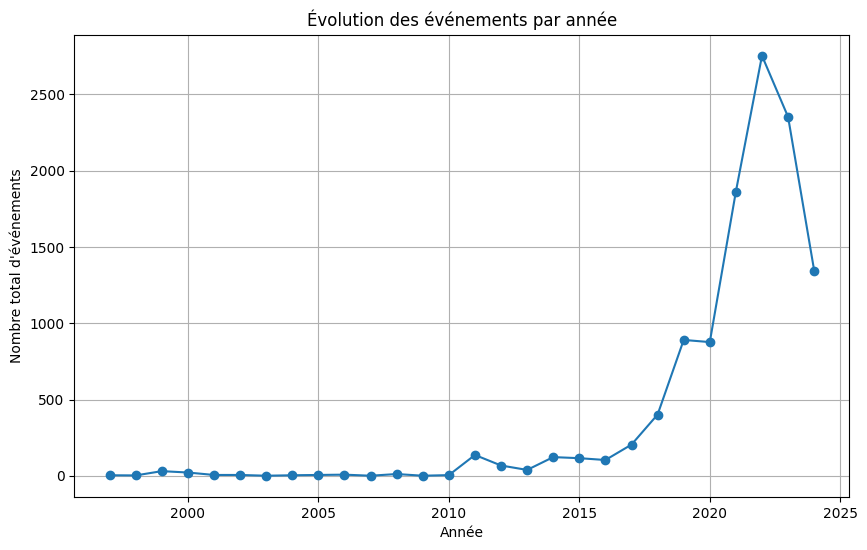

In [11]:
years = burkina_points['year'].unique()  # Liste des années
rasters = {}  # Dictionnaire pour stocker les rasters par année

pixel_size = 5000 / 111320  # 5 km en degrés
xmin, ymin, xmax, ymax = burkina_points['longitude'].min(), burkina_points['latitude'].min(), burkina_points['longitude'].max(), burkina_points['latitude'].max()
width = int((xmax - xmin) / pixel_size)
height = int((ymax - ymin) / pixel_size)
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

for year in years:
    yearly_data = burkina_points[burkina_points['year'] == year]  #on filtre nos année
    years = burkina_points['year'].unique()  # Liste des année
    rasters = {}  # Dictionnaire pour stocker les rasters par année

pixel_size = 5000 / 111320  # on converti
xmin, ymin, xmax, ymax = burkina_points['longitude'].min(), burkina_points['latitude'].min(), burkina_points['longitude'].max(), burkina_points['latitude'].max()
width = int((xmax - xmin) / pixel_size)
height = int((ymax - ymin)/pixel_size)
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

for year in years:
    yearly_data = burkina_points[burkina_points['year'] == year]  # on Filtre par année
    geometry = [Point(xy) for xy in zip(yearly_data['longitude'], yearly_data['latitude'])]
    gdf = gpd.GeoDataFrame(yearly_data, geometry=geometry)

    #on crée nos raster
    raster_data = np.zeros((height, width), dtype=int)
    for point in gdf.geometry:
        x, y = ~transform * (point.x, point.y)
        row, col = int(y), int(x)
        if 0 <= row < height and 0 <= col < width:
            raster_data[row, col] += 1

    rasters[year] = raster_data  # Stocker le raster dans le dictionnaire

    # on enregistre
    with rasterio.open(
        f'raster_{year}.tif', 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=raster_data.dtype,
        crs="EPSG:4326",
        transform=transform
         ) as dst:
              dst.write(raster_data, 1)
              gdf = gpd.GeoDataFrame(yearly_data, geometry=geometry)
                                                                        # Enregistrement (optionnel)
with rasterio.open(
   f'raster_{year}.tif', 'w',
   driver='GTiff',
   height=height,
   width=width,
   count=1,
   dtype=raster_data.dtype,
   crs="EPSG:4326",
   transform=transform
   ) as dst:
       dst.write(raster_data, 1)
event_counts = {year: np.sum(rasters[year]) for year in years}

plt.figure(figsize=(10, 6))
plt.plot(sorted(event_counts.keys()), [event_counts[year] for year in sorted(event_counts.keys())], marker='o')
plt.title("Évolution des événements par année")
plt.xlabel("Année")
plt.ylabel("Nombre total d'événements")
plt.grid(True)
plt.show()


In [12]:
#on verifie les raster
raster_sums = {year: np.sum(raster) for year, raster in rasters.items()}
original_sums = burkina_points.groupby('year').size().to_dict()
for year in years:
      raster_sum = raster_sums.get(year, 0)
      original_sum = original_sums.get(year, 0)
      print(f"Année: {year}")
      print(f"  Points dans le raster: {raster_sum}")
      print(f"  Points dans les données d'origine: {original_sum}")
      if raster_sum == original_sum:
        print("  ✅ Les sommes correspondent.")
      else:
        print("  ❌ Les sommes ne correspondent pas.")

Année: 2024
  Points dans le raster: 1346
  Points dans les données d'origine: 1349
  ❌ Les sommes ne correspondent pas.
Année: 2023
  Points dans le raster: 2353
  Points dans les données d'origine: 2353
  ✅ Les sommes correspondent.
Année: 2022
  Points dans le raster: 2754
  Points dans les données d'origine: 2754
  ✅ Les sommes correspondent.
Année: 2021
  Points dans le raster: 1864
  Points dans les données d'origine: 1864
  ✅ Les sommes correspondent.
Année: 2020
  Points dans le raster: 877
  Points dans les données d'origine: 877
  ✅ Les sommes correspondent.
Année: 2019
  Points dans le raster: 891
  Points dans les données d'origine: 891
  ✅ Les sommes correspondent.
Année: 2018
  Points dans le raster: 402
  Points dans les données d'origine: 402
  ✅ Les sommes correspondent.
Année: 2017
  Points dans le raster: 205
  Points dans les données d'origine: 205
  ✅ Les sommes correspondent.
Année: 2016
  Points dans le raster: 104
  Points dans les données d'origine: 104
  ✅ Les

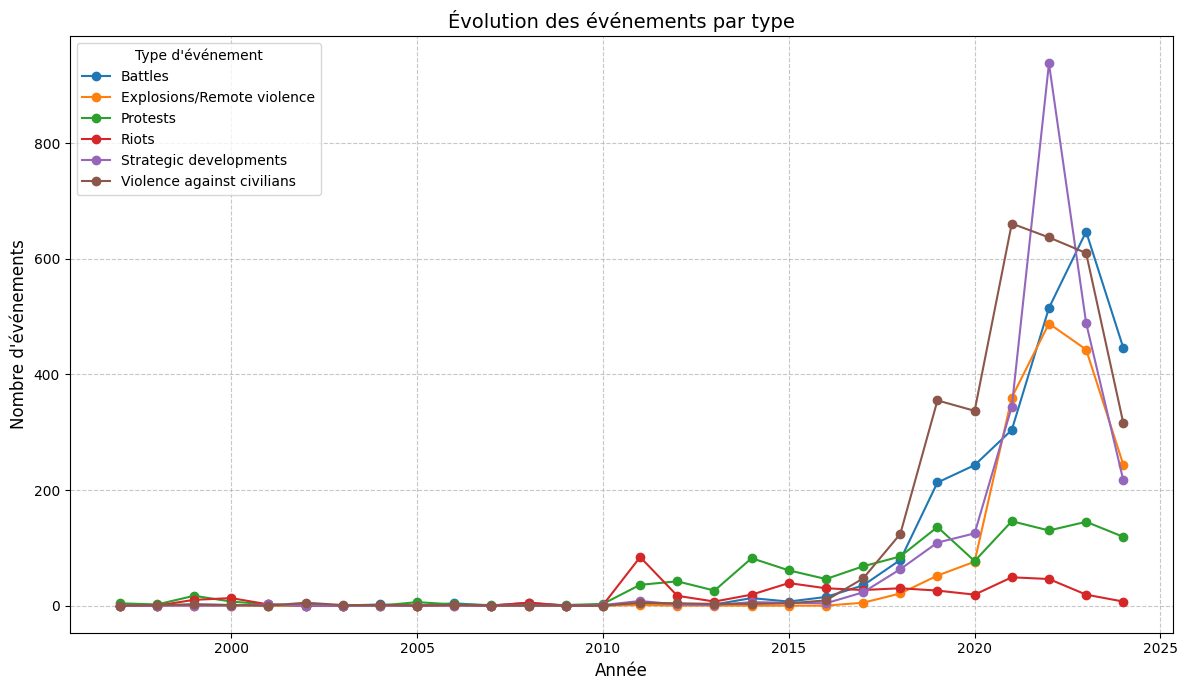

In [13]:


# Étape 1 : Compter le nombre d'événements par année et par type
event_counts_by_type = burkina_points.groupby(['year', 'event_type']).size().reset_index(name='count')

# Étape 2 : Transformer en une table croisée (années en index, types en colonnes)
event_counts_pivot = event_counts_by_type.pivot(index='year', columns='event_type', values='count').fillna(0)

# Étape 3 : Visualisation avec des séries temporelles
plt.figure(figsize=(12, 7))
for event_type in event_counts_pivot.columns:
    plt.plot(
    event_counts_pivot.index,
    event_counts_pivot[event_type],
    marker='o',
    label=event_type
            )

# Étape 4 : Personnaliser le graphique
plt.title("Évolution des événements par type", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre d'événements", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Type d'événement", fontsize=10, loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Fin du TP6